In [1]:
from __future__ import print_function
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
import numpy as np 
import pandas as pd 
import time
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.datasets import make_multilabel_classification
from xgboost import XGBClassifier
from sklearn.model_selection import KFold
from sklearn.multioutput import MultiOutputClassifier
from sklearn.pipeline import Pipeline

from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif, chi2, f_classif
#from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import validation_curve
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

%matplotlib inline

In [2]:
df = pd.read_csv('./Liver_GSE14520_U133A.csv')

# Data Exploratation

Dataset GSE14520 on Liver cancer gene expression from CuMiDa

- 2 classes
- 22279 genes
- 357 samples

In [3]:
df.shape

(357, 22279)

In [4]:
df.head()

,samples,type,1007_s_at,1053_at,117_at,121_at,1255_g_at,1294_at,1316_at,1320_at,...,AFFX-r2-Ec-bioD-3_at,AFFX-r2-Ec-bioD-5_at,AFFX-r2-P1-cre-3_at,AFFX-r2-P1-cre-5_at,AFFX-ThrX-3_at,AFFX-ThrX-5_at,AFFX-ThrX-M_at,AFFX-TrpnX-3_at,AFFX-TrpnX-5_at,AFFX-TrpnX-M_at
0,GSM362958.CEL.gz,HCC,6.801198,4.553189,6.787790,5.430893,3.250222,6.272688,3.413405,3.374910,...,10.735084,10.398843,12.298551,12.270505,3.855588,3.148321,3.366087,3.199008,3.160388,3.366417
1,GSM362959.CEL.gz,HCC,7.585956,4.193540,3.763183,6.003593,3.309387,6.291927,3.754777,3.587603,...,11.528447,11.369919,12.867048,12.560433,4.016561,3.282867,3.541994,3.548680,3.460083,3.423348
2,GSM362960.CEL.gz,HCC,7.803370,4.134075,3.433113,5.395057,3.476944,5.825713,3.505036,3.687333,...,10.892460,10.416151,12.356337,11.888482,3.839367,3.598851,3.516791,3.484089,3.282626,3.512024
3,GSM362964.CEL.gz,HCC,6.920840,4.000651,3.754500,5.645297,3.387530,6.470458,3.629249,3.577534,...,10.686871,10.524836,12.006596,11.846195,3.867602,3.180472,3.309547,3.425501,3.166613,3.377499
4,GSM362965.CEL.gz,HCC,6.556480,4.599010,4.066155,6.344537,3.372081,5.439280,3.762213,3.440714,...,11.014454,10.775566,12.657182,12.573076,4.091440,3.306729,3.493704,3.205771,3.378567,3.392938


Checking target column values

In [5]:
df.type.isnull().sum()

0

In [6]:
df.type.value_counts()

HCC       181
normal    176
Name: type, dtype: int64

The target colum values are balanced and no null values exist.

In [7]:
max_value = df.drop(['type','samples'],axis=1).max().max()
print(f'Max value across all genes :{max_value}')

Max value across all genes :14.2845689567055


In [8]:
min_value = df.drop(['type','samples'],axis=1).min().min()
print(f'Min value across all genes :{min_value}')

Min value across all genes :2.49106381646662


# Data Visiualization

Boxplot of some randomly selected genes

In [9]:
sample_df = df.drop(['type','samples'],axis=1).sample(n=5,axis='columns',random_state=22)
sample_df.describe()

,203380_x_at,211224_s_at,221092_at,219279_at,205605_at
count,357.000000,357.000000,357.000000,357.000000,357.000000
mean,9.017054,4.695510,3.449816,3.759549,3.582705
std,0.459521,0.967952,0.197730,0.459393,0.209077
min,7.385061,3.037065,3.083345,2.998020,3.148123
25%,8.778733,3.830298,3.327087,3.452017,3.439907
50%,9.120436,4.628020,3.415459,3.666093,3.542227
75%,9.333791,5.378825,3.537291,4.003379,3.709221
max,10.100178,7.050719,4.985782,5.661041,4.739721


<AxesSubplot:>

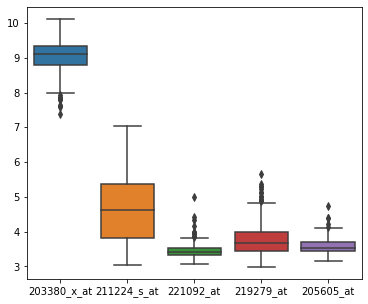

In [10]:
plt.figure(figsize = (6,5))
sns.boxplot(data=sample_df)

T-SNE plot of data

C:\Users\esraa\anaconda3\envs\NLP_PY_3\lib\site-packages\sklearn\manifold\_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\esraa\anaconda3\envs\NLP_PY_3\lib\site-packages\sklearn\manifold\_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


tsne data dim: (357, 2)


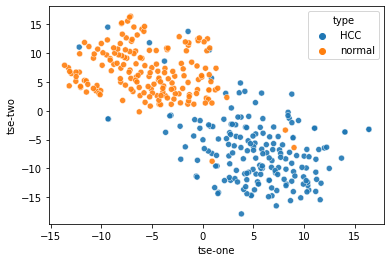

In [11]:
def plot_tsne(data_mat,labels):
    df_tsne = pd.DataFrame()
    tsne = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=300,random_state=44)
    tsne_results = tsne.fit_transform(data_mat)
    print(f'tsne data dim: {tsne_results.shape}')
    df_tsne['tse-one'] = tsne_results[:,0]
    df_tsne['tse-two'] = tsne_results[:,1]
    sns.scatterplot(
        x=df_tsne['tse-one'], y=df_tsne['tse-two'],
        hue=labels,
        legend="full",
        alpha=0.9)

plot_tsne(df.iloc[:,2:],df.iloc[:,1])

Bar plot for target column

<AxesSubplot:xlabel='type', ylabel='count'>

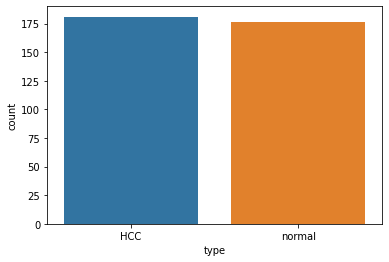

In [12]:
sns.countplot(x=df['type'],order = df['type'].value_counts(normalize=True).index)

# Data Preparaition

To get the gene names, the probe IDs (which are the feature names) were extracted and written to an external dataframe.

In [13]:
df.columns[2:]
probe_ids_df=pd.DataFrame(columns=['ProbeID','Gene'])
probe_ids_df['ProbeID']=df.columns[2:]
probe_ids_df.to_csv('./ProbeIDs.csv')

This dataframe was used in RStudio to select the corresponding probe information. The data was saved in Mapping.csv that will be loaded here for further processing

In [14]:
Mapping_df = pd.read_csv('./Mapping.csv')
Mapping_df.head()

,affy_hg_u133_plus_2,ensembl_gene_id,gene_biotype,external_gene_name,p_value
0,201104_x_at,ENSG00000271254,protein_coding,NaN,NaN
1,202809_s_at,ENSG00000262826,protein_coding,INTS3,NaN
2,204166_at,ENSG00000278788,protein_coding,SBNO2,NaN
3,202809_s_at,ENSG00000263163,protein_coding,SLC27A3,NaN
4,201681_s_at,ENSG00000274429,protein_coding,DLG5,NaN


In [15]:
Mapping_df['affy_hg_u133_plus_2'].nunique()

20210

In [16]:
#drop prob IDs that don't have a gene name
Filteres_mapping_df=Mapping_df.dropna(subset=['external_gene_name'])
Filteres_mapping_df['affy_hg_u133_plus_2'].nunique()

20028

In [17]:
#count the probe id
len(Filteres_mapping_df)

25326

In [18]:
Filteres_mapping_df.loc[Filteres_mapping_df['affy_hg_u133_plus_2'].isin(['1007_s_at','AFFX-r2-Ec-bioD-3_at','117_at','121_at','1255_g_at']) ]

,affy_hg_u133_plus_2,ensembl_gene_id,gene_biotype,external_gene_name,p_value
288,1007_s_at,ENSG00000234078,protein_coding,DDR1,NaN
358,1007_s_at,ENSG00000215522,protein_coding,DDR1,NaN
372,1007_s_at,ENSG00000137332,protein_coding,DDR1,NaN
448,1007_s_at,ENSG00000230456,protein_coding,DDR1,NaN
3721,1007_s_at,ENSG00000204580,protein_coding,DDR1,NaN
4134,117_at,ENSG00000173110,protein_coding,HSPA6,NaN
4135,117_at,ENSG00000225217,unprocessed_pseudogene,HSPA7,NaN
4576,121_at,ENSG00000125618,protein_coding,PAX8,NaN
4782,1255_g_at,ENSG00000048545,protein_coding,GUCA1A,NaN


Some probe ids are repeated, we need to keep only one probe id

In [19]:
unique_probes=Filteres_mapping_df.drop_duplicates(subset = ['affy_hg_u133_plus_2'], keep = 'first')
display(unique_probes)

,affy_hg_u133_plus_2,ensembl_gene_id,gene_biotype,external_gene_name,p_value
1,202809_s_at,ENSG00000262826,protein_coding,INTS3,NaN
2,204166_at,ENSG00000278788,protein_coding,SBNO2,NaN
4,201681_s_at,ENSG00000274429,protein_coding,DLG5,NaN
5,203122_at,ENSG00000274891,protein_coding,TRAPPC12,NaN
6,202245_at,ENSG00000281289,protein_coding,LSS,NaN
...,...,...,...,...,...
26527,222054_at,ENSG00000243970,transcribed_unprocessed_pseudogene,PPIEL,NaN
26528,220387_s_at,ENSG00000197568,lncRNA,HHLA3,NaN
26531,222301_at,ENSG00000125462,lncRNA,MIR9-1HG,NaN
26532,219131_at,ENSG00000120942,protein_coding,UBIAD1,NaN


Update the original data column names with genes

In [20]:
#getting a list of the col names that have a gene mapping
common_probe_ids = ['type']
common_probe_ids += ( set(df.columns[2:]) & set(unique_probes['affy_hg_u133_plus_2']))
print(f'Common probe ids count = {str(len(common_probe_ids))}')
#drop the columns not found in the list
filtered_df = df[df.columns.intersection(common_probe_ids)]

Common probe ids count = 20029


In [21]:
filtered_df = filtered_df.rename(columns=dict(zip(unique_probes['affy_hg_u133_plus_2'], unique_probes['external_gene_name'])))
display(filtered_df)

,type,DDR1,RFC2,HSPA6,PAX8,GUCA1A,UBA7,THRA,PTPN21,CCL5,...,ACTB,ACTB,GAPDH,GAPDH,GAPDH,STAT1,STAT1,STAT1,STAT1,MIR3648-2
0,HCC,6.801198,4.553189,6.787790,5.430893,3.250222,6.272688,3.413405,3.374910,3.654116,...,8.925829,10.577185,12.434618,10.053507,11.399226,8.887026,3.484061,5.223046,5.106557,5.812552
1,HCC,7.585956,4.193540,3.763183,6.003593,3.309387,6.291927,3.754777,3.587603,5.137159,...,8.560630,10.242594,12.305758,9.534238,11.164706,8.902539,3.565290,5.336692,4.610203,6.466670
2,HCC,7.803370,4.134075,3.433113,5.395057,3.476944,5.825713,3.505036,3.687333,4.515175,...,6.834969,9.285009,11.664887,8.251444,10.295777,8.680812,3.576893,4.915993,4.394337,6.398943
3,HCC,6.920840,4.000651,3.754500,5.645297,3.387530,6.470458,3.629249,3.577534,5.192624,...,9.323089,10.816136,11.811286,10.395842,11.151115,8.850918,3.581794,5.680709,5.676981,4.573412
4,HCC,6.556480,4.599010,4.066155,6.344537,3.372081,5.439280,3.762213,3.440714,4.961625,...,9.622091,11.067973,11.761827,10.268784,11.257260,8.006895,3.476417,5.095280,4.758499,5.551629
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
352,normal,6.857025,3.965635,3.883590,6.190071,3.054398,6.339694,3.993988,3.566907,5.193377,...,7.810763,9.409347,11.738196,9.697882,10.600680,7.645199,3.614560,5.097731,4.796082,6.454016
353,normal,7.291103,3.779197,4.024521,5.456527,3.275127,5.870166,3.872936,3.729544,5.704730,...,9.968584,10.716753,11.265742,10.319129,10.473690,7.755645,3.767891,4.831031,5.244616,6.863219
354,normal,7.493958,4.200727,3.791528,5.576578,3.118160,5.400790,3.927906,3.421077,4.284763,...,6.645715,8.733632,11.992407,9.347654,10.826936,9.676892,5.389918,6.270020,6.001944,13.476380
355,normal,6.835236,4.112805,3.907909,5.786022,3.164424,5.996150,4.019206,3.533469,5.472988,...,7.655441,9.381813,11.509496,9.632247,10.563275,8.382818,4.621180,4.992820,5.098811,13.783683


In [22]:
filtered_df.shape

(357, 20029)

Now we have a dataframe that includes sample type (cancer/normal) and the gene expression value for every gene reference

In [23]:
#filtered_df.to_csv('./SamplesGenesDataset.csv')

Dividing data into features and a target column

In [24]:
X=filtered_df.drop(columns='type')
y=filtered_df['type']

Converting target column to binary format

In [25]:
y = df['type'].replace(['HCC','normal'],[1,0])
y

0      1
1      1
2      1
3      1
4      1
      ..
352    0
353    0
354    0
355    0
356    0
Name: type, Length: 357, dtype: int64

# Feature Engineering

In [26]:
def convert_to_labels(enc_labels):
    dec_labels = np.where(enc_labels == 0, 'normal', enc_labels)
    dec_labels = np.where(enc_labels == 1, 'HCC', dec_labels)
    return dec_labels

## Splitting data

Splitting data into training and testing

In [27]:
xtrain, xtest, ytrain, ytest=train_test_split(X, y, train_size=0.7, random_state=88)
print(len(xtrain))

249


Visualizing training data using tsne

C:\Users\esraa\anaconda3\envs\NLP_PY_3\lib\site-packages\sklearn\manifold\_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\esraa\anaconda3\envs\NLP_PY_3\lib\site-packages\sklearn\manifold\_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


tsne data dim: (249, 2)


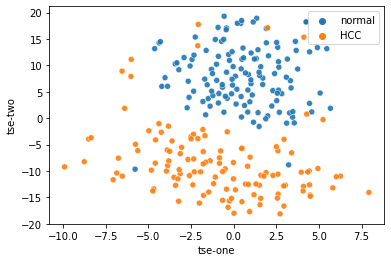

In [28]:
plot_tsne(xtrain,convert_to_labels(ytrain))

## PCA

Number of components: 74


Text(0, 0.5, 'Explained variance (%)')

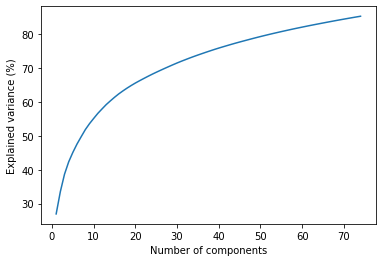

In [29]:
pca = PCA(n_components = 0.85,random_state=55)
pca.fit(xtrain)
# print("Cumulative Variances (Percentage):")
# print(np.cumsum(pca.explained_variance_ratio_ * 100))
components = len(pca.explained_variance_ratio_)
print(f'Number of components: {components}')
# Make the scree plot
plt.plot(range(1, components + 1), np.cumsum(pca.explained_variance_ratio_ * 100))
plt.xlabel("Number of components")
plt.ylabel("Explained variance (%)")

In [30]:
pca_components = abs(pca.components_)
#print(pca_components)
#print('Top 4 most important features in each component')
#print('===============================================')
pca_biomarkers = []
for row in range(pca_components.shape[0]):
    # get the indices of the top 4 values in each row
    temp = np.argpartition(-(pca_components[row]), 4)
    
    # sort the indices in descending order
    indices = temp[np.argsort((-pca_components[row])[temp])][:4]
    
    # print the top 4 feature names
    #print(f'Component {row}: {X.columns[indices].to_list()}')
    pca_biomarkers += xtrain.columns[indices].to_list()

In [31]:
pca_biomarkers_df = (Filteres_mapping_df.loc[Filteres_mapping_df['external_gene_name'].isin(set(pca_biomarkers))]).copy()
pca_biomarkers_df.reset_index(inplace=True)
display(pca_biomarkers_df)

,index,affy_hg_u133_plus_2,ensembl_gene_id,gene_biotype,external_gene_name,p_value
0,43,203146_s_at,ENSG00000237051,protein_coding,GABBR1,NaN
1,51,203146_s_at,ENSG00000232569,protein_coding,GABBR1,NaN
2,101,203815_at,ENSG00000277656,protein_coding,GSTT1,NaN
3,173,203146_s_at,ENSG00000232632,protein_coding,GABBR1,NaN
4,181,203146_s_at,ENSG00000206511,protein_coding,GABBR1,NaN
...,...,...,...,...,...,...
244,25674,219295_s_at,ENSG00000163710,protein_coding,PCOLCE2,NaN
245,25795,220437_at,ENSG00000130173,protein_coding,ANGPTL8,NaN
246,26091,220491_at,ENSG00000105697,protein_coding,HAMP,NaN
247,26362,33323_r_at,ENSG00000175793,protein_coding,SFN,NaN


Using PCA **249** biomarkers were identified

In [32]:
x_pca_train = pca.transform(xtrain)
x_pca_test = pca.transform(xtest)

### Visualizing data after PCA

In [33]:
df_processed=pd.DataFrame()

In [34]:
df_processed['pca-one'] = x_pca_train[:,0]
df_processed['pca-two'] = x_pca_train[:,1] 
df_processed['pca-three'] = x_pca_train[:,2]
df_processed['type'] = filtered_df['type']

<AxesSubplot:>

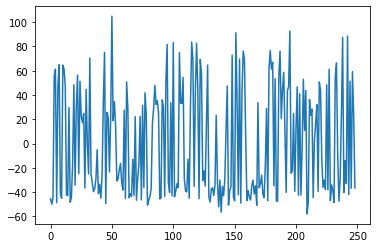

In [35]:
df_processed['pca-one'].plot()

<AxesSubplot:xlabel='pca-one', ylabel='pca-two'>

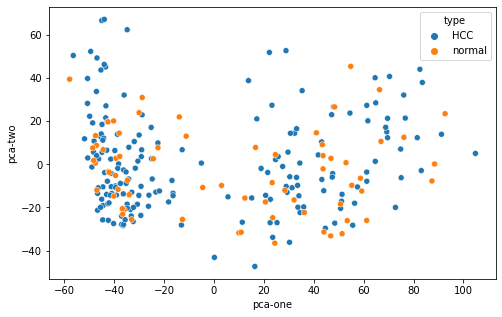

In [36]:
plt.figure(figsize=(8,5))
sns.scatterplot(
    x=df_processed['pca-one'], y=df_processed['pca-two'],
    hue=df_processed['type'],
    legend="full",
)

C:\Users\esraa\AppData\Local\Temp\ipykernel_31884\3767905541.py:1: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = plt.figure(figsize=(16,10)).gca(projection='3d')


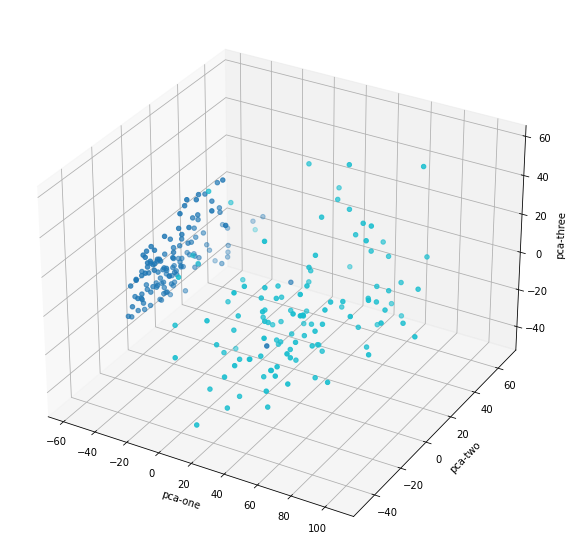

In [37]:
ax = plt.figure(figsize=(16,10)).gca(projection='3d')
ax.scatter(
    zs=df_processed['pca-three'] ,
    xs=df_processed['pca-one'], 
    ys=df_processed['pca-two'] ,
    c=ytrain, 
    cmap='tab10'
)
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')
plt.show()

C:\Users\esraa\anaconda3\envs\NLP_PY_3\lib\site-packages\sklearn\manifold\_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\esraa\anaconda3\envs\NLP_PY_3\lib\site-packages\sklearn\manifold\_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


tsne data dim: (249, 2)


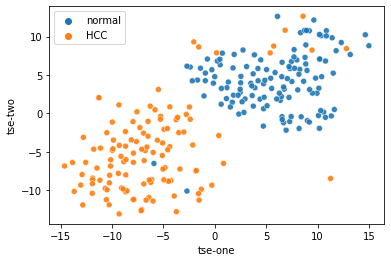

In [38]:
plot_tsne(x_pca_train,convert_to_labels(ytrain))

## Feature Selection

In [39]:
col_num=xtrain.shape[1]

sub_data=[]
for i in [1, 2, 3, 4, 5, 10]:
    d=(i/100)*col_num
    sub_data.append(int(d))
sub_data

def select_feature(X_train, y_train, X_test, y_test, FSM, model):
    fs = FSM
    fs.fit(X_train, y_train.values.ravel())
    X_train_new = fs.transform(X_train)
    X_test_new = fs.transform(X_test) 
    model.fit(X_train_new, y_train.values.ravel())
    y_pred = model.predict(X_test_new)
    acc = accuracy_score(y_test, y_pred) * 100
  
    return acc,fs.get_support(indices=True)

def filter_selecton(x_train1, y_train1, x_test1, y_test1,  model_name,m,sub_data):
    accuracy_dic={}
    accuracy_list=[]
    accuracy_list2=[]
    feat_name=[]
    model = model_name
    for i in sub_data:
        fsm =  SelectKBest(chi2, k=i)
        acc,fn = select_feature(x_train1, y_train1, x_test1, y_test1, fsm, model)
        accuracy_list.append(acc)
        feat_name.append(fn)
 
   
    print('max mutal',max(accuracy_list))
    best_n=sub_data[accuracy_list.index(max(accuracy_list))]
    print("Best value of n components: ",best_n, "from chi2 ")
    return feat_name[accuracy_list.index(max(accuracy_list))]

xtrain_subset, xval, ytrain_subset, yval=train_test_split(xtrain, ytrain, train_size=0.9, random_state=88)
fn=filter_selecton(xtrain_subset, ytrain_subset, xval, yval,  svm.SVC(),"SVM",sub_data)

cl=[]
for col in fn:
    cl.append(xtrain.columns[col])

max mutal 96.0
Best value of n components:  200 from chi2 


In [40]:
x_sel_train=xtrain[cl]
x_sel_test=xtest[cl]


### Visualizing data after Feature Selection

C:\Users\esraa\anaconda3\envs\NLP_PY_3\lib\site-packages\sklearn\manifold\_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\esraa\anaconda3\envs\NLP_PY_3\lib\site-packages\sklearn\manifold\_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


tsne data dim: (249, 2)


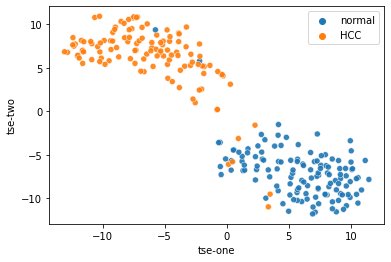

In [41]:
plot_tsne(x_sel_train,convert_to_labels(ytrain))

# Model creation

In [42]:
def plot_cv_indices(clf, X, y,param_name,parameter_range,  cv=10,model_name ="SVM"):
 
    train_score, test_score = validation_curve(clf, X, y,
                                           param_name = param_name,
                                           param_range = parameter_range,
                                            cv = cv, scoring = "accuracy",n_jobs=2)

    # Calculating mean and standard deviation of training score
    mean_train_score = np.mean(train_score, axis = 1)
    std_train_score = np.std(train_score, axis = 1)

    # Calculating mean and standard deviation of testing score
    mean_test_score = np.mean(test_score, axis = 1)
    std_test_score = np.std(test_score, axis = 1)

    # Plot mean accuracy scores for training and testing scores
    plt.plot(parameter_range, mean_train_score,
       label = "Training Score", color = 'b')
    plt.plot(parameter_range, mean_test_score,
     label = "Cross Validation Score", color = 'g')

    # Creating the plot
    plt.title(f"Validation Curve with {model_name} Classifier")
    plt.xlabel(f"Value of {param_name}")
    plt.ylabel("Accuracy")
    plt.tight_layout()
    plt.legend(loc = 'best')
    plt.show()

def mesure_cross_validation(clf, X_train, y_train, cv=10):
    scores = cross_val_score(clf, X_train, y_train, cv=cv)
    print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
    print("K-fold cross validation score: fo each ",scores)
    return scores

## NB Classifier

### Using PCA Features

In [43]:
NB_model = MultinomialNB()

**Using K-Fold to evaluate model**

Accuracy: 0.91 (+/- 0.08)
K-fold cross validation score: fo each  [0.88       0.88       0.96       0.88       0.96       0.92
 0.96       0.92       0.84       0.91666667]


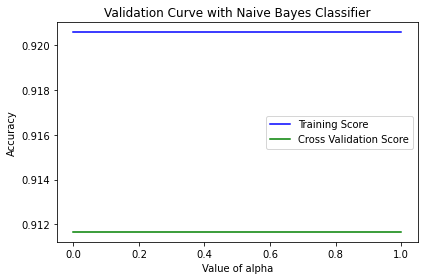

In [44]:
mesure_cross_validation(NB_model, abs(x_pca_train), ytrain)
param_range = np.arange(0, 1.1, 0.1)
#get the best value for alpha hyperparameter
plot_cv_indices(NB_model,abs(x_pca_train), ytrain,"alpha", param_range ,  cv=10 ,model_name = "Naive Bayes")

### Using Feature Selection Features

**Using K-Fold to evaluate model**

Accuracy: 0.95 (+/- 0.08)
K-fold cross validation score: fo each  [1.         0.88       0.88       0.96       1.         0.96
 0.96       0.96       0.96       0.91666667]


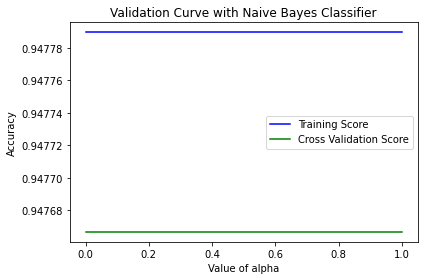

In [45]:
mesure_cross_validation(NB_model, abs(x_sel_train), ytrain)
param_range = np.arange(0, 1.1, 0.1)
plot_cv_indices(NB_model,abs(x_sel_train), ytrain,"alpha", param_range ,  cv=10 ,model_name = "Naive Bayes")

## SVM

### Using PCA Features

In [46]:
svm_model= svm.SVC()

**Using K-Fold to evaluate model**

Accuracy: 0.97 (+/- 0.04)
K-fold cross validation score: fo each  [1.         0.96       0.96       0.96       1.         1.
 0.96       0.96       0.96       0.95833333]


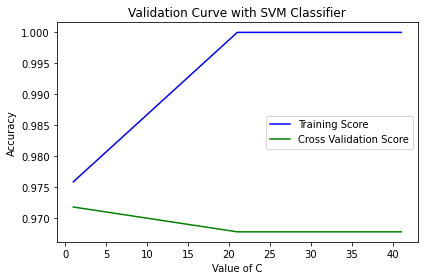

In [47]:
mesure_cross_validation(svm_model,x_pca_train, ytrain)
param_range = np.arange(1, 50, 20)
#get the best value for C hyperparameter
plot_cv_indices(svm_model, x_pca_train, ytrain,"C", param_range ,  cv=10 ,model_name = "SVM")

### Using Feature Selection Features

**Using K-Fold to evaluate model**

Accuracy: 0.97 (+/- 0.03)
K-fold cross validation score: fo each  [1.         0.96       0.96       0.96       1.         0.96
 0.96       0.96       0.96       0.95833333]


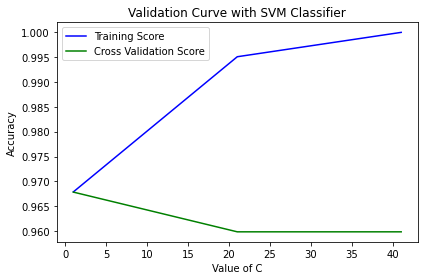

In [48]:
mesure_cross_validation(svm_model,x_sel_train, ytrain)
param_range = np.arange(1, 50, 20)
plot_cv_indices(svm_model, x_sel_train, ytrain,"C", param_range ,  cv=10 ,model_name = "SVM")

# Best Model

The best model was **SVM**

In [49]:
model = svm.SVC(C=1.0,random_state=22)
#predict
model.fit(x_pca_train,ytrain)
y_predict=model.predict(x_pca_test)

## Evaluation

In [50]:
def plot_class_metrics(y_test,y_pred):
    print(confusion_matrix(y_test, y_pred))
    ax = sns.heatmap(confusion_matrix(y_test,y_pred ), annot=True, cmap='PuBuGn')
    plt.xlabel('Predicted', fontsize=18)
    plt.ylabel('Actual', fontsize=18)
    plt.show()
    print(classification_report(y_test,y_pred))


[[45  2]
 [ 2 59]]


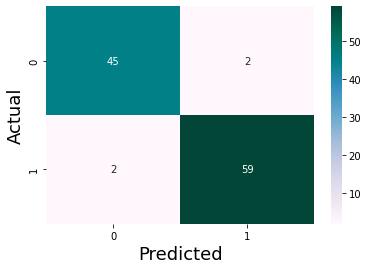

              precision    recall  f1-score   support

           0       0.96      0.96      0.96        47
           1       0.97      0.97      0.97        61

    accuracy                           0.96       108
   macro avg       0.96      0.96      0.96       108
weighted avg       0.96      0.96      0.96       108



In [51]:
plot_class_metrics(ytest, y_predict)

